In [1]:
!git clone https://github.com/chickowar/6-sem-CV-dz-4

Cloning into '6-sem-CV-dz-4'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 39 (delta 15), reused 24 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (39/39), 13.35 KiB | 6.68 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [2]:
%cd 6-sem-CV-dz-4/

/content/6-sem-CV-dz-4


In [3]:
import sys
sys.path.append('./src') # чтобы он видел модуль src

In [4]:
from src.datasets import get_mnist, get_svhn
from src.dann_model import FeatureExtractor, LabelClassifier, DomainDiscriminator
from src.dann_train import train_dann, alpha_schedule
from src.train_eval import evaluate
import torch
import torch.optim as optim
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# мокаем загрузку из github, потому что мне впадлу

In [23]:
from tqdm import tqdm

In [39]:
def train_dann(
    feature_extractor,
    label_classifier,
    domain_discriminator,
    source_loader,
    target_loader,
    device,
    epochs=10,
    alpha_schedule=None,
    lambda_domain=1.0,  # добавим вес
    batch_size = 128,
    evaluate_fn = None,
    target_test_loader = None,
):
    feature_extractor.to(device)
    label_classifier.to(device)
    domain_discriminator.to(device)

    optimizer_F = torch.optim.Adam(feature_extractor.parameters(), lr=1e-4)
    optimizer_C = torch.optim.Adam(label_classifier.parameters(), lr=1e-4)
    optimizer_D = torch.optim.Adam(domain_discriminator.parameters(), lr=1e-4)

    cls_criterion = nn.CrossEntropyLoss()
    domain_criterion = nn.BCEWithLogitsLoss()

    max_step = len(source_loader)

    target_accs = []  # сюда будем писать accuracy по target_test

    for epoch in range(epochs):
        feature_extractor.train()
        label_classifier.train()
        domain_discriminator.train()

        total_cls_loss = 0
        total_domain_loss = 0

        for step, ((src_x, src_y), (tgt_x, _)) in enumerate(tqdm(zip(source_loader, target_loader), total=max_step, desc=f"Epoch {epoch+1}")):
            src_x, src_y = src_x.to(device), src_y.to(device)
            tgt_x = tgt_x.to(device)

            src_bs = src_x.size(0)
            tgt_bs = tgt_x.size(0)
            all_x = torch.cat([src_x, tgt_x], dim=0)

            alpha = alpha_schedule(epoch, step, max_epoch=epochs, max_step=max_step)
            if step == 0:
                print(f"[Epoch {epoch+1}] alpha = {alpha:.3f}")

            features = feature_extractor(all_x)
            class_preds = label_classifier(features[:src_bs])
            domain_preds = domain_discriminator(features, alpha)

            domain_src = torch.ones((src_bs, 1)).to(device)
            domain_tgt = torch.zeros((tgt_bs, 1)).to(device)

            loss_cls = cls_criterion(class_preds, src_y)
            loss_domain = domain_criterion(domain_preds[:src_bs], domain_src) + \
                          domain_criterion(domain_preds[src_bs:], domain_tgt)

            loss = loss_cls + lambda_domain * loss_domain

            optimizer_F.zero_grad()
            optimizer_C.zero_grad()
            optimizer_D.zero_grad()

            loss.backward()
            optimizer_F.step()
            optimizer_C.step()
            optimizer_D.step()

            total_cls_loss += loss_cls.item()
            total_domain_loss += loss_domain.item()

        print(f"Epoch {epoch+1}: loss_cls={total_cls_loss/max_step:.4f} | loss_domain={total_domain_loss/max_step:.4f}")

        # evaluate на целевом тесте
        if evaluate_fn is not None and target_test_loader is not None:
            model = nn.Sequential(feature_extractor, label_classifier)
            acc = evaluate_fn(model, target_test_loader, device)
            print(f"Epoch {epoch+1}: target_test accuracy = {acc:.4f}")
            target_accs.append(acc)

    return target_accs


# Загрузка датасетов и модельки

In [30]:
source_loader = get_mnist(train=True)
target_loader = get_svhn()
source_test = get_mnist(train=False)
target_test = get_svhn()

In [40]:
F = FeatureExtractor()
C = LabelClassifier()
D = DomainDiscriminator()

# Обучение

In [59]:
import numpy as np
import matplotlib.pyplot as plt

def alpha_schedule(epoch, step, max_epoch=15, max_step=500, k=5.0):
    """Более плавный рост alpha."""
    p = float(epoch * max_step + step) / (max_epoch * max_step)
    return 2. / (1. + np.exp(-k * p)) - 1


## lambda_domain = 0.3

In [60]:
target_accs = train_dann(
    F, C, D,
    source_loader, target_loader,
    device,
    epochs=15,
    alpha_schedule=alpha_schedule,
    lambda_domain=0.3,
    evaluate_fn = evaluate, target_test_loader=target_test

)

Epoch 1:   0%|          | 2/469 [00:00<00:35, 13.19it/s]

[Epoch 1] alpha = 0.000


Epoch 1:  43%|████▎     | 204/469 [00:15<00:19, 13.49it/s]


Epoch 1: loss_cls=0.0151 | loss_domain=0.0393
Accuracy: 30.30%
Epoch 1: target_test accuracy = 30.3012


Epoch 2:   0%|          | 2/469 [00:00<00:33, 14.12it/s]

[Epoch 2] alpha = 0.165


Epoch 2:  43%|████▎     | 204/469 [00:15<00:19, 13.39it/s]


Epoch 2: loss_cls=0.0129 | loss_domain=0.0110
Accuracy: 28.11%
Epoch 2: target_test accuracy = 28.1077


Epoch 3:   0%|          | 2/469 [00:00<00:43, 10.73it/s]

[Epoch 3] alpha = 0.322


Epoch 3:  43%|████▎     | 204/469 [00:15<00:20, 13.16it/s]


Epoch 3: loss_cls=0.0115 | loss_domain=0.0147
Accuracy: 27.05%
Epoch 3: target_test accuracy = 27.0513


Epoch 4:   0%|          | 2/469 [00:00<00:32, 14.18it/s]

[Epoch 4] alpha = 0.462


Epoch 4:  43%|████▎     | 204/469 [00:15<00:20, 12.80it/s]


Epoch 4: loss_cls=0.0164 | loss_domain=0.1904
Accuracy: 25.68%
Epoch 4: target_test accuracy = 25.6838


Epoch 5:   0%|          | 2/469 [00:00<00:31, 14.65it/s]

[Epoch 5] alpha = 0.583


Epoch 5:  43%|████▎     | 204/469 [00:15<00:19, 13.45it/s]


Epoch 5: loss_cls=0.0139 | loss_domain=0.0395
Accuracy: 27.14%
Epoch 5: target_test accuracy = 27.1358


Epoch 6:   0%|          | 2/469 [00:00<00:32, 14.33it/s]

[Epoch 6] alpha = 0.682


Epoch 6:  43%|████▎     | 204/469 [00:15<00:19, 13.42it/s]


Epoch 6: loss_cls=0.0114 | loss_domain=0.0273
Accuracy: 26.79%
Epoch 6: target_test accuracy = 26.7901


Epoch 7:   0%|          | 2/469 [00:00<00:32, 14.38it/s]

[Epoch 7] alpha = 0.762


Epoch 7:  43%|████▎     | 204/469 [00:15<00:19, 13.43it/s]


Epoch 7: loss_cls=0.0120 | loss_domain=0.0607
Accuracy: 27.16%
Epoch 7: target_test accuracy = 27.1627


Epoch 8:   0%|          | 2/469 [00:00<00:39, 11.91it/s]

[Epoch 8] alpha = 0.823


Epoch 8:  43%|████▎     | 204/469 [00:15<00:19, 13.27it/s]


Epoch 8: loss_cls=0.0199 | loss_domain=0.1239
Accuracy: 26.33%
Epoch 8: target_test accuracy = 26.3330


Epoch 9:   0%|          | 2/469 [00:00<00:32, 14.33it/s]

[Epoch 9] alpha = 0.870


Epoch 9:  43%|████▎     | 204/469 [00:16<00:20, 12.73it/s]


Epoch 9: loss_cls=0.0171 | loss_domain=0.1116
Accuracy: 25.85%
Epoch 9: target_test accuracy = 25.8490


Epoch 10:   0%|          | 2/469 [00:00<00:31, 14.65it/s]

[Epoch 10] alpha = 0.905


Epoch 10:  43%|████▎     | 204/469 [00:15<00:19, 13.52it/s]


Epoch 10: loss_cls=0.0124 | loss_domain=0.0217
Accuracy: 25.14%
Epoch 10: target_test accuracy = 25.1421


Epoch 11:   0%|          | 2/469 [00:00<00:33, 14.00it/s]

[Epoch 11] alpha = 0.931


Epoch 11:  43%|████▎     | 204/469 [00:15<00:19, 13.46it/s]


Epoch 11: loss_cls=0.0223 | loss_domain=0.2042
Accuracy: 27.59%
Epoch 11: target_test accuracy = 27.5853


Epoch 12:   0%|          | 2/469 [00:00<00:33, 13.89it/s]

[Epoch 12] alpha = 0.950


Epoch 12:  43%|████▎     | 204/469 [00:15<00:19, 13.34it/s]


Epoch 12: loss_cls=0.0166 | loss_domain=0.0261
Accuracy: 25.94%
Epoch 12: target_test accuracy = 25.9373


Epoch 13:   0%|          | 2/469 [00:00<00:33, 13.86it/s]

[Epoch 13] alpha = 0.964


Epoch 13:  43%|████▎     | 204/469 [00:16<00:21, 12.53it/s]


Epoch 13: loss_cls=0.0141 | loss_domain=0.0140
Accuracy: 27.53%
Epoch 13: target_test accuracy = 27.5277


Epoch 14:   0%|          | 2/469 [00:00<00:35, 12.99it/s]

[Epoch 14] alpha = 0.974


Epoch 14:  43%|████▎     | 204/469 [00:16<00:20, 12.67it/s]


Epoch 14: loss_cls=0.0116 | loss_domain=0.0114
Accuracy: 28.04%
Epoch 14: target_test accuracy = 28.0424


Epoch 15:   0%|          | 2/469 [00:00<00:31, 14.89it/s]

[Epoch 15] alpha = 0.981


Epoch 15:  43%|████▎     | 204/469 [00:15<00:20, 13.24it/s]


Epoch 15: loss_cls=0.0108 | loss_domain=0.0121
Accuracy: 25.73%
Epoch 15: target_test accuracy = 25.7337


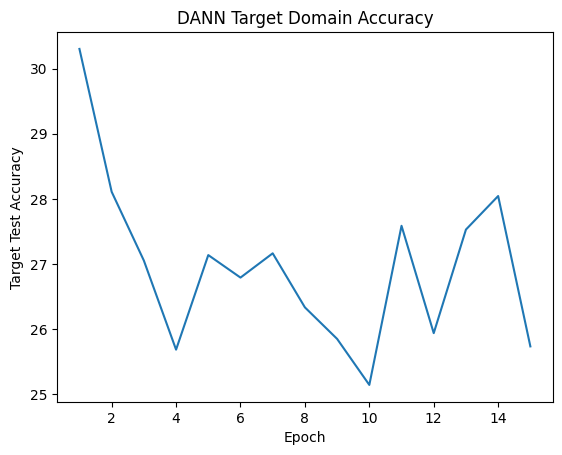

In [61]:
plt.plot(range(1, len(target_accs)+1), target_accs)
plt.xlabel("Epoch")
plt.ylabel("Target Test Accuracy")
plt.title("DANN Target Domain Accuracy")
plt.show()

In [62]:
print("Eval on Source (MNIST):")
evaluate(nn.Sequential(F, C), source_test, device)

Eval on Source (MNIST):
Accuracy: 99.04%


99.04

## lambda_domain = 0.5

In [63]:
target_accs = train_dann(
    F, C, D,
    source_loader, target_loader,
    device,
    epochs=15,
    alpha_schedule=alpha_schedule,
    lambda_domain=0.5,
    evaluate_fn = evaluate, target_test_loader=target_test

)

Epoch 1:   0%|          | 2/469 [00:00<00:32, 14.48it/s]

[Epoch 1] alpha = 0.000


Epoch 1:  43%|████▎     | 204/469 [00:15<00:20, 12.80it/s]


Epoch 1: loss_cls=0.0096 | loss_domain=0.0085
Accuracy: 28.32%
Epoch 1: target_test accuracy = 28.3228


Epoch 2:   0%|          | 2/469 [00:00<00:33, 14.13it/s]

[Epoch 2] alpha = 0.165


Epoch 2:  43%|████▎     | 204/469 [00:15<00:19, 13.27it/s]


Epoch 2: loss_cls=0.0086 | loss_domain=0.0051
Accuracy: 27.64%
Epoch 2: target_test accuracy = 27.6429


Epoch 3:   0%|          | 2/469 [00:00<00:36, 12.63it/s]

[Epoch 3] alpha = 0.322


Epoch 3:  43%|████▎     | 204/469 [00:15<00:20, 13.23it/s]


Epoch 3: loss_cls=0.0086 | loss_domain=0.0061
Accuracy: 29.26%
Epoch 3: target_test accuracy = 29.2601


Epoch 4:   0%|          | 2/469 [00:00<00:32, 14.54it/s]

[Epoch 4] alpha = 0.462


Epoch 4:  43%|████▎     | 204/469 [00:15<00:19, 13.45it/s]


Epoch 4: loss_cls=0.0120 | loss_domain=0.0716
Accuracy: 31.32%
Epoch 4: target_test accuracy = 31.3230


Epoch 5:   0%|          | 2/469 [00:00<00:41, 11.24it/s]

[Epoch 5] alpha = 0.583


Epoch 5:  43%|████▎     | 204/469 [00:15<00:20, 13.17it/s]


Epoch 5: loss_cls=0.0396 | loss_domain=0.3565
Accuracy: 26.52%
Epoch 5: target_test accuracy = 26.5212


Epoch 6:   0%|          | 2/469 [00:00<00:34, 13.50it/s]

[Epoch 6] alpha = 0.682


Epoch 6:  43%|████▎     | 204/469 [00:15<00:20, 12.85it/s]


Epoch 6: loss_cls=0.0331 | loss_domain=0.2020
Accuracy: 27.02%
Epoch 6: target_test accuracy = 27.0167


Epoch 7:   0%|          | 2/469 [00:00<00:33, 13.79it/s]

[Epoch 7] alpha = 0.762


Epoch 7:  43%|████▎     | 204/469 [00:15<00:19, 13.29it/s]


Epoch 7: loss_cls=0.2343 | loss_domain=2.0044
Accuracy: 20.86%
Epoch 7: target_test accuracy = 20.8628


Epoch 8:   0%|          | 2/469 [00:00<00:35, 13.11it/s]

[Epoch 8] alpha = 0.823


Epoch 8:  43%|████▎     | 204/469 [00:15<00:19, 13.26it/s]


Epoch 8: loss_cls=0.1147 | loss_domain=0.7115
Accuracy: 18.63%
Epoch 8: target_test accuracy = 18.6271


Epoch 9:   0%|          | 2/469 [00:00<00:36, 12.78it/s]

[Epoch 9] alpha = 0.870


Epoch 9:  43%|████▎     | 204/469 [00:15<00:19, 13.35it/s]


Epoch 9: loss_cls=0.2418 | loss_domain=1.4959
Accuracy: 20.08%
Epoch 9: target_test accuracy = 20.0830


Epoch 10:   0%|          | 1/469 [00:00<00:52,  8.92it/s]

[Epoch 10] alpha = 0.905


Epoch 10:  43%|████▎     | 204/469 [00:15<00:20, 13.16it/s]


Epoch 10: loss_cls=0.2825 | loss_domain=1.5691
Accuracy: 17.29%
Epoch 10: target_test accuracy = 17.2864


Epoch 11:   0%|          | 2/469 [00:00<00:32, 14.55it/s]

[Epoch 11] alpha = 0.931


Epoch 11:  43%|████▎     | 204/469 [00:16<00:20, 12.68it/s]


Epoch 11: loss_cls=0.2392 | loss_domain=1.1953
Accuracy: 14.54%
Epoch 11: target_test accuracy = 14.5436


Epoch 12:   0%|          | 2/469 [00:00<00:33, 13.79it/s]

[Epoch 12] alpha = 0.950


Epoch 12:  43%|████▎     | 204/469 [00:15<00:19, 13.43it/s]


Epoch 12: loss_cls=0.2031 | loss_domain=0.9121
Accuracy: 13.41%
Epoch 12: target_test accuracy = 13.4143


Epoch 13:   0%|          | 2/469 [00:00<00:32, 14.53it/s]

[Epoch 13] alpha = 0.964


Epoch 13:  43%|████▎     | 204/469 [00:15<00:19, 13.54it/s]


Epoch 13: loss_cls=0.1835 | loss_domain=0.7548
Accuracy: 14.50%
Epoch 13: target_test accuracy = 14.5014


Epoch 14:   0%|          | 2/469 [00:00<00:33, 14.03it/s]

[Epoch 14] alpha = 0.974


Epoch 14:  43%|████▎     | 204/469 [00:15<00:19, 13.38it/s]


Epoch 14: loss_cls=0.1664 | loss_domain=0.6574
Accuracy: 14.84%
Epoch 14: target_test accuracy = 14.8394


Epoch 15:   0%|          | 1/469 [00:00<00:50,  9.33it/s]

[Epoch 15] alpha = 0.981


Epoch 15:  43%|████▎     | 204/469 [00:15<00:20, 13.03it/s]


Epoch 15: loss_cls=0.1396 | loss_domain=0.5379
Accuracy: 15.77%
Epoch 15: target_test accuracy = 15.7729


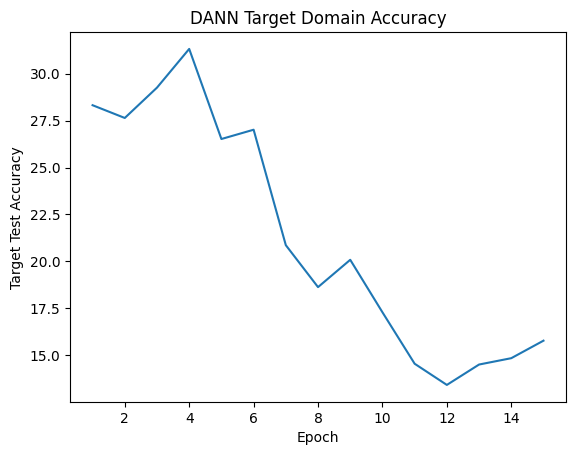

In [64]:
plt.plot(range(1, len(target_accs)+1), target_accs)
plt.xlabel("Epoch")
plt.ylabel("Target Test Accuracy")
plt.title("DANN Target Domain Accuracy")
plt.show()

In [65]:
print("Eval on Source (MNIST):")
evaluate(nn.Sequential(F, C), source_test, device)

Eval on Source (MNIST):
Accuracy: 93.77%


93.77

## 0.7

In [66]:
target_accs = train_dann(
    F, C, D,
    source_loader, target_loader,
    device,
    epochs=15,
    alpha_schedule=alpha_schedule,
    lambda_domain=0.7,
    evaluate_fn = evaluate, target_test_loader=target_test

)

Epoch 1:   0%|          | 1/469 [00:00<00:58,  8.03it/s]

[Epoch 1] alpha = 0.000


Epoch 1:  43%|████▎     | 204/469 [00:16<00:21, 12.59it/s]


Epoch 1: loss_cls=0.0671 | loss_domain=0.2139
Accuracy: 15.87%
Epoch 1: target_test accuracy = 15.8689


Epoch 2:   0%|          | 1/469 [00:00<00:53,  8.80it/s]

[Epoch 2] alpha = 0.165


Epoch 2:  43%|████▎     | 204/469 [00:16<00:21, 12.54it/s]


Epoch 2: loss_cls=0.0513 | loss_domain=0.1451
Accuracy: 16.49%
Epoch 2: target_test accuracy = 16.4912


Epoch 3:   0%|          | 2/469 [00:00<00:45, 10.30it/s]

[Epoch 3] alpha = 0.322


Epoch 3:  43%|████▎     | 204/469 [00:16<00:20, 12.62it/s]


Epoch 3: loss_cls=0.0630 | loss_domain=0.3068
Accuracy: 17.32%
Epoch 3: target_test accuracy = 17.3171


Epoch 4:   0%|          | 2/469 [00:00<00:34, 13.54it/s]

[Epoch 4] alpha = 0.462


Epoch 4:  43%|████▎     | 204/469 [00:15<00:20, 13.06it/s]


Epoch 4: loss_cls=0.0547 | loss_domain=0.1404
Accuracy: 20.36%
Epoch 4: target_test accuracy = 20.3634


Epoch 5:   0%|          | 2/469 [00:00<00:33, 14.15it/s]

[Epoch 5] alpha = 0.583


Epoch 5:  43%|████▎     | 204/469 [00:15<00:19, 13.47it/s]


Epoch 5: loss_cls=0.0699 | loss_domain=0.2957
Accuracy: 22.84%
Epoch 5: target_test accuracy = 22.8411


Epoch 6:   0%|          | 2/469 [00:00<00:32, 14.32it/s]

[Epoch 6] alpha = 0.682


Epoch 6:  43%|████▎     | 204/469 [00:15<00:20, 13.17it/s]


Epoch 6: loss_cls=0.0650 | loss_domain=0.2436
Accuracy: 21.61%
Epoch 6: target_test accuracy = 21.6119


Epoch 7:   0%|          | 2/469 [00:00<00:32, 14.35it/s]

[Epoch 7] alpha = 0.762


Epoch 7:  43%|████▎     | 204/469 [00:15<00:20, 13.20it/s]


Epoch 7: loss_cls=0.0765 | loss_domain=0.2831
Accuracy: 21.57%
Epoch 7: target_test accuracy = 21.5658


Epoch 8:   0%|          | 2/469 [00:00<00:32, 14.57it/s]

[Epoch 8] alpha = 0.823


Epoch 8:  43%|████▎     | 204/469 [00:15<00:19, 13.34it/s]


Epoch 8: loss_cls=0.0946 | loss_domain=0.3592
Accuracy: 22.62%
Epoch 8: target_test accuracy = 22.6183


Epoch 9:   0%|          | 1/469 [00:00<00:50,  9.24it/s]

[Epoch 9] alpha = 0.870


Epoch 9:  43%|████▎     | 204/469 [00:15<00:20, 12.87it/s]


Epoch 9: loss_cls=0.0847 | loss_domain=0.3319
Accuracy: 24.80%
Epoch 9: target_test accuracy = 24.8002


Epoch 10:   0%|          | 2/469 [00:00<00:35, 13.31it/s]

[Epoch 10] alpha = 0.905


Epoch 10:  43%|████▎     | 204/469 [00:15<00:20, 13.13it/s]


Epoch 10: loss_cls=0.0916 | loss_domain=0.3593
Accuracy: 22.56%
Epoch 10: target_test accuracy = 22.5645


Epoch 11:   0%|          | 2/469 [00:00<00:32, 14.51it/s]

[Epoch 11] alpha = 0.931


Epoch 11:  43%|████▎     | 204/469 [00:15<00:20, 12.81it/s]


Epoch 11: loss_cls=0.0984 | loss_domain=0.3685
Accuracy: 26.48%
Epoch 11: target_test accuracy = 26.4828


Epoch 12:   0%|          | 2/469 [00:00<00:33, 14.07it/s]

[Epoch 12] alpha = 0.950


Epoch 12:  43%|████▎     | 204/469 [00:15<00:20, 13.06it/s]


Epoch 12: loss_cls=0.1000 | loss_domain=0.3823
Accuracy: 24.12%
Epoch 12: target_test accuracy = 24.1165


Epoch 13:   0%|          | 2/469 [00:00<00:33, 13.86it/s]

[Epoch 13] alpha = 0.964


Epoch 13:  43%|████▎     | 204/469 [00:15<00:19, 13.50it/s]


Epoch 13: loss_cls=0.1061 | loss_domain=0.3980
Accuracy: 23.96%
Epoch 13: target_test accuracy = 23.9551


Epoch 14:   0%|          | 1/469 [00:00<00:49,  9.41it/s]

[Epoch 14] alpha = 0.974


Epoch 14:  43%|████▎     | 204/469 [00:15<00:20, 13.21it/s]


Epoch 14: loss_cls=0.1039 | loss_domain=0.4138
Accuracy: 21.96%
Epoch 14: target_test accuracy = 21.9576


Epoch 15:   0%|          | 2/469 [00:00<00:35, 13.22it/s]

[Epoch 15] alpha = 0.981


Epoch 15:  43%|████▎     | 204/469 [00:15<00:19, 13.32it/s]


Epoch 15: loss_cls=0.1102 | loss_domain=0.4293
Accuracy: 23.26%
Epoch 15: target_test accuracy = 23.2598


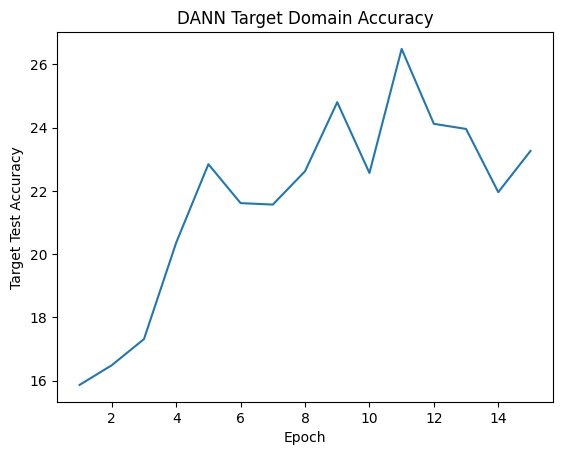

In [67]:
plt.plot(range(1, len(target_accs)+1), target_accs)
plt.xlabel("Epoch")
plt.ylabel("Target Test Accuracy")
plt.title("DANN Target Domain Accuracy")
plt.show()

In [68]:
print("Eval on Source (MNIST):")
evaluate(nn.Sequential(F, C), source_test, device)

Eval on Source (MNIST):
Accuracy: 94.85%


94.85

## lamda_domain = 1.0

In [70]:
target_accs = train_dann(
    F, C, D,
    source_loader, target_loader,
    device,
    epochs=15,
    alpha_schedule=alpha_schedule,
    lambda_domain=1.0,
    evaluate_fn = evaluate, target_test_loader=target_test

)

Epoch 1:   0%|          | 2/469 [00:00<00:47,  9.75it/s]

[Epoch 1] alpha = 0.000


Epoch 1:  43%|████▎     | 204/469 [00:15<00:19, 13.36it/s]


Epoch 1: loss_cls=0.0451 | loss_domain=0.1987
Accuracy: 24.81%
Epoch 1: target_test accuracy = 24.8118


Epoch 2:   0%|          | 2/469 [00:00<00:31, 14.86it/s]

[Epoch 2] alpha = 0.165


Epoch 2:  43%|████▎     | 204/469 [00:15<00:19, 13.25it/s]


Epoch 2: loss_cls=0.0445 | loss_domain=0.2232
Accuracy: 25.55%
Epoch 2: target_test accuracy = 25.5455


Epoch 3:   0%|          | 2/469 [00:00<00:32, 14.50it/s]

[Epoch 3] alpha = 0.322


Epoch 3:  43%|████▎     | 204/469 [00:14<00:19, 13.64it/s]


Epoch 3: loss_cls=0.0689 | loss_domain=0.3032
Accuracy: 25.84%
Epoch 3: target_test accuracy = 25.8413


Epoch 4:   0%|          | 2/469 [00:00<00:32, 14.48it/s]

[Epoch 4] alpha = 0.462


Epoch 4:  43%|████▎     | 204/469 [00:14<00:19, 13.78it/s]


Epoch 4: loss_cls=0.0797 | loss_domain=0.3256
Accuracy: 26.42%
Epoch 4: target_test accuracy = 26.4175


Epoch 5:   0%|          | 0/469 [00:00<?, ?it/s]

[Epoch 5] alpha = 0.583


Epoch 5:  43%|████▎     | 204/469 [00:15<00:19, 13.60it/s]


Epoch 5: loss_cls=0.1105 | loss_domain=0.4067
Accuracy: 22.76%
Epoch 5: target_test accuracy = 22.7643


Epoch 6:   0%|          | 2/469 [00:00<00:32, 14.55it/s]

[Epoch 6] alpha = 0.682


Epoch 6:  43%|████▎     | 204/469 [00:15<00:20, 13.12it/s]


Epoch 6: loss_cls=0.2251 | loss_domain=1.4183
Accuracy: 19.26%
Epoch 6: target_test accuracy = 19.2571


Epoch 7:   0%|          | 2/469 [00:00<00:31, 14.76it/s]

[Epoch 7] alpha = 0.762


Epoch 7:  43%|████▎     | 204/469 [00:14<00:19, 13.67it/s]


Epoch 7: loss_cls=0.2765 | loss_domain=1.6351
Accuracy: 19.08%
Epoch 7: target_test accuracy = 19.0842


Epoch 8:   0%|          | 2/469 [00:00<00:31, 14.66it/s]

[Epoch 8] alpha = 0.823


Epoch 8:  43%|████▎     | 204/469 [00:14<00:19, 13.73it/s]


Epoch 8: loss_cls=0.1872 | loss_domain=0.5643
Accuracy: 21.65%
Epoch 8: target_test accuracy = 21.6541


Epoch 9:   0%|          | 2/469 [00:00<00:31, 14.62it/s]

[Epoch 9] alpha = 0.870


Epoch 9:  43%|████▎     | 204/469 [00:14<00:19, 13.74it/s]


Epoch 9: loss_cls=0.1636 | loss_domain=0.4490
Accuracy: 28.43%
Epoch 9: target_test accuracy = 28.4342


Epoch 10:   0%|          | 2/469 [00:00<00:31, 14.73it/s]

[Epoch 10] alpha = 0.905


Epoch 10:  43%|████▎     | 204/469 [00:15<00:20, 13.00it/s]


Epoch 10: loss_cls=0.1364 | loss_domain=0.4289
Accuracy: 29.88%
Epoch 10: target_test accuracy = 29.8786


Epoch 11:   0%|          | 2/469 [00:00<00:36, 12.63it/s]

[Epoch 11] alpha = 0.931


Epoch 11:  43%|████▎     | 204/469 [00:14<00:19, 13.70it/s]


Epoch 11: loss_cls=0.1525 | loss_domain=0.4592
Accuracy: 31.23%
Epoch 11: target_test accuracy = 31.2270


Epoch 12:   0%|          | 2/469 [00:00<00:31, 14.81it/s]

[Epoch 12] alpha = 0.950


Epoch 12:  43%|████▎     | 204/469 [00:14<00:19, 13.62it/s]


Epoch 12: loss_cls=0.1328 | loss_domain=0.4457
Accuracy: 30.90%
Epoch 12: target_test accuracy = 30.8966


Epoch 13:   0%|          | 2/469 [00:00<00:37, 12.41it/s]

[Epoch 13] alpha = 0.964


Epoch 13:  43%|████▎     | 204/469 [00:14<00:19, 13.73it/s]


Epoch 13: loss_cls=0.1412 | loss_domain=0.4495
Accuracy: 28.78%
Epoch 13: target_test accuracy = 28.7800


Epoch 14:   0%|          | 2/469 [00:00<00:42, 10.97it/s]

[Epoch 14] alpha = 0.974


Epoch 14:  43%|████▎     | 204/469 [00:16<00:20, 12.63it/s]


Epoch 14: loss_cls=0.1241 | loss_domain=0.4381
Accuracy: 27.02%
Epoch 14: target_test accuracy = 27.0167


Epoch 15:   0%|          | 2/469 [00:00<00:33, 13.80it/s]

[Epoch 15] alpha = 0.981


Epoch 15:  43%|████▎     | 204/469 [00:15<00:19, 13.53it/s]


Epoch 15: loss_cls=0.1518 | loss_domain=0.4645
Accuracy: 26.43%
Epoch 15: target_test accuracy = 26.4329


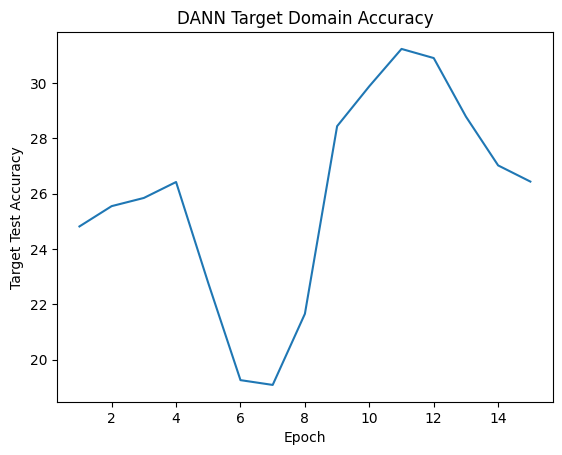

In [71]:
plt.plot(range(1, len(target_accs)+1), target_accs)
plt.xlabel("Epoch")
plt.ylabel("Target Test Accuracy")
plt.title("DANN Target Domain Accuracy")
plt.show()

In [72]:
print("Eval on Source (MNIST):")
evaluate(nn.Sequential(F, C), source_test, device)

Eval on Source (MNIST):
Accuracy: 92.45%


92.45